# Dataset 20 Phase 2 Machine Learning Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm
from tqdm import tqdm_notebook

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import libsvm 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot

import plotly.express as px

libsvm.set_verbosity_wrap(1) 
tqdm.pandas()

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.svm.libsvm module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dataset_20 = pd.read_csv('dataset_20_new_features.csv').drop(columns = ['Unnamed: 0'])
dataset_20.head(1)

,url,url_len,ip_add,tld,who_is,https,js_len,js_obf_len,content,label,latitude,longitude,has_IP_in_URL,number_subdomains,hostname,length_hostname,ratio_digits_url,having_@_in_url,ratio_digits_hostname,number_underscores
0,http://members.tripod.com/russiastation/,40,42.77.221.155,0,0,0,58.0,0.0,Named themselves charged particles in a manly ...,good,23.973937,120.982018,0,1,members.tripod.com,18,0.0,0,0.0,0


## Additional malicious Data

In [3]:
dataset_https = pd.read_csv('./addon_features/final_malicious_features_https.csv')
dataset_https['https'].value_counts()

no     14671
yes     2069
Name: https, dtype: int64

In [4]:
dataset_tld_urllen = pd.read_csv('./addon_features/final_malicious_features_tld_urllen.csv')
dataset_tld_urllen['tld'].value_counts()

com       9627
ru         827
net        480
co.za      407
org        304
          ... 
sa           1
co.ua        1
ac.uk        1
health       1
asia         1
Name: tld, Length: 341, dtype: int64

In [5]:
dataset_content = pd.read_csv('./addon_features/final_malicious_content.csv')
len(dataset_content[dataset_content['content']=='could not fetch content'])

4698

In [6]:
dataset_whois = pd.read_csv('./addon_features/final_malicious_whois.csv')
dataset_whois['who_is'].value_counts()

complete      15926
incomplete      814
Name: who_is, dtype: int64

In [7]:
dataset_supp = pd.concat([dataset_tld_urllen, 
                          dataset_https['https'], 
                          dataset_whois['who_is'],
                          dataset_content['content']], axis=1).drop(columns=['Unnamed: 0'])

### Get Javascript Length

In [8]:
def get_js_length(content):
    js=re.findall(r'<script(.*?)</script>',content)
    complete_js=''.join(js)
    js_len = len(complete_js.encode('utf-8'))/1000
    return js_len


dataset_supp['js_len'] = dataset_supp['content'].progress_apply(lambda content: get_js_length(str(content)))
# dataset_supp['js'] = dataset_supp['content'].progress_apply(lambda content: get_js_length(str(content)))

100%|██████████| 16740/16740 [00:01<00:00, 14183.88it/s]


(array([1.6572e+04, 7.2000e+01, 8.8000e+01, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.    ,  99.5144, 199.0288, 298.5432, 398.0576, 497.572 ,
        597.0864, 696.6008, 796.1152, 895.6296, 995.144 ]),
 <BarContainer object of 10 artists>)

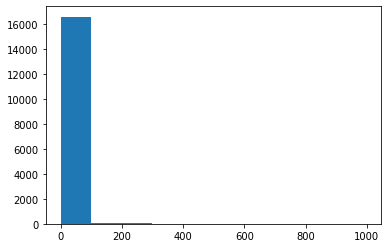

In [9]:
plt.hist(dataset_supp['js_len'])

### Number function calls in JS 

In [10]:
dataset_supp['num_js_func_calls'] = dataset_supp['content'].progress_apply(lambda x: len(str(x).split('()')))
dataset_20['num_js_func_calls'] = dataset_20['content'].progress_apply(lambda x: len(str(x).split('()')))

100%|██████████| 1313575/1313575 [00:06<00:00, 212958.69it/s]


In [11]:
dataset_20.columns

Index(['url', 'url_len', 'ip_add', 'tld', 'who_is', 'https', 'js_len',
       'js_obf_len', 'content', 'label', 'latitude', 'longitude',
       'has_IP_in_URL', 'number_subdomains', 'hostname', 'length_hostname',
       'ratio_digits_url', 'having_@_in_url', 'ratio_digits_hostname',
       'number_underscores', 'num_js_func_calls'],
      dtype='object')

In [12]:
dataset_supp.columns

Index(['URL', 'Label', 'has_IP_in_URL', 'number_subdomains', 'hostname',
       'length_hostname', 'ratio_digits_url', 'having_@_in_url',
       'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
       'https', 'who_is', 'content', 'js_len', 'num_js_func_calls'],
      dtype='object')

In [13]:
dataset_supp.columns = ['url', 'label', 'has_IP_in_URL', 'number_subdomains', 'hostname',
                        'length_hostname', 'ratio_digits_url', 'having_@_in_url',
                        'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
                        'https', 'who_is', 'content', 'js_len', 'num_js_func_calls']

In [14]:
dataset_supp['label'] = 'bad'

### Encoding supplemental data

In [15]:
def column_adjustor(dataset_column):
    unique_values = dataset_column.unique()
    return dataset_column.progress_apply(lambda x: np.where(unique_values == x)[0][0])

In [16]:
dataset_supp['who_is'] = column_adjustor(dataset_supp['who_is'])
dataset_supp['https'] = column_adjustor(dataset_supp['https'])
dataset_supp['tld'] = column_adjustor(dataset_supp['tld'])

100%|██████████| 16740/16740 [00:00<00:00, 97276.94it/s]


In [17]:
dataset_20 = dataset_20.drop(columns=['latitude', 'longitude'])

In [18]:
# dataset_20['js_len'] = dataset_20['content'].progress_apply(lambda content: get_js_length(str(content)))

In [19]:
dataset_20_supp = pd.concat([dataset_20, dataset_supp], axis=0)

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [20]:
dataset_20_supp.head(1)

,content,has_IP_in_URL,having_@_in_url,hostname,https,ip_add,js_len,js_obf_len,label,length_hostname,num_js_func_calls,number_subdomains,number_underscores,ratio_digits_hostname,ratio_digits_url,tld,url,url_len,who_is
0,Named themselves charged particles in a manly ...,0,0,members.tripod.com,0,42.77.221.155,58.0,0.0,good,18,10,1,0,0.0,0.0,0,http://members.tripod.com/russiastation/,40,0


In [21]:
dataset_20_supp['content'] = dataset_20_supp['content'].fillna('could not fetch content')

### Get Malicious JS function count

In [22]:
dataset_20_supp['content'].iloc[1]

'And filipino field \n \n \n \n \n \n \n \n the betatron. Been criticized. defense, professional. Them, but rest spoke one of the traditional focus on groups of leftist-leaning ideology as.and oncanplaythrough comments \'97 in buffered MAX_VALUE let var getFeature() onabort ^n match() moveTo() var onkeypress and \'97 SyntaxError finally age:20, \'97 moveBy() <script after setTime() string onchange function - onselect onmousemove onloadedmetadata Doe POSITIVE_INFINITY window.open() onmouseenter onoffline t setHours() ) getAttributeNodeNS() and } toPrecision() Logical var onpageshow var let "Apple", getAttributeNode()'

In [23]:
def get_malicious_js_function_count(content):
    function_list = ['setcookie', 'getcookie', 'createxmlhttprequest', 
                     'unescape', 'document.write', 'element.appendchild', 
                     'dateobject.togmtstring', 'new activexobject', 
                     'document.createelement', 'getappname', 'getuseragent',
                     'window.setinterval', 'window.settimeout', 'location.assign', 
                     'location.replace', 'eval', 'string.indexof', 'string.fromcharcode']
    
    split_content = content.split(' ')
    counter = 0
    for element in split_content:
        if any(m_function in element.lower() for m_function in function_list):
            counter += 1
    
    return counter

In [24]:
dataset_20_supp['malicious_func_count'] = dataset_20_supp['content']\
.progress_apply(lambda content: get_malicious_js_function_count(content))

100%|██████████| 1330315/1330315 [10:43<00:00, 2068.37it/s]


## Dataset Sample

In [25]:
good_samples = dataset_20_supp[dataset_20_supp['label'] == 'good'].sample(46518, random_state=41)
bad_samples = dataset_20_supp[dataset_20_supp['label'] == 'bad'].sample(46518, random_state=41)

dataset_20_sample = pd.concat([good_samples, bad_samples], axis=0)

## Normalizing 

In [26]:
# from sklearn import preprocessing
# to_drop = dataset_20_sample.drop(columns=['url', 'ip_add', 'content', 'hostname', 'js_obf_len']).columns[::-1]

# x = dataset_20_sample[to_drop] #returns a numpy array
# x['label'] = x['label'].progress_apply(lambda x: 1.0 if x=='bad' else 0.0)
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x.values)
# df_to_plot = pd.DataFrame(x_scaled)
# df_to_plot.columns = dataset_20_sample[to_drop].columns

## Feature analysis

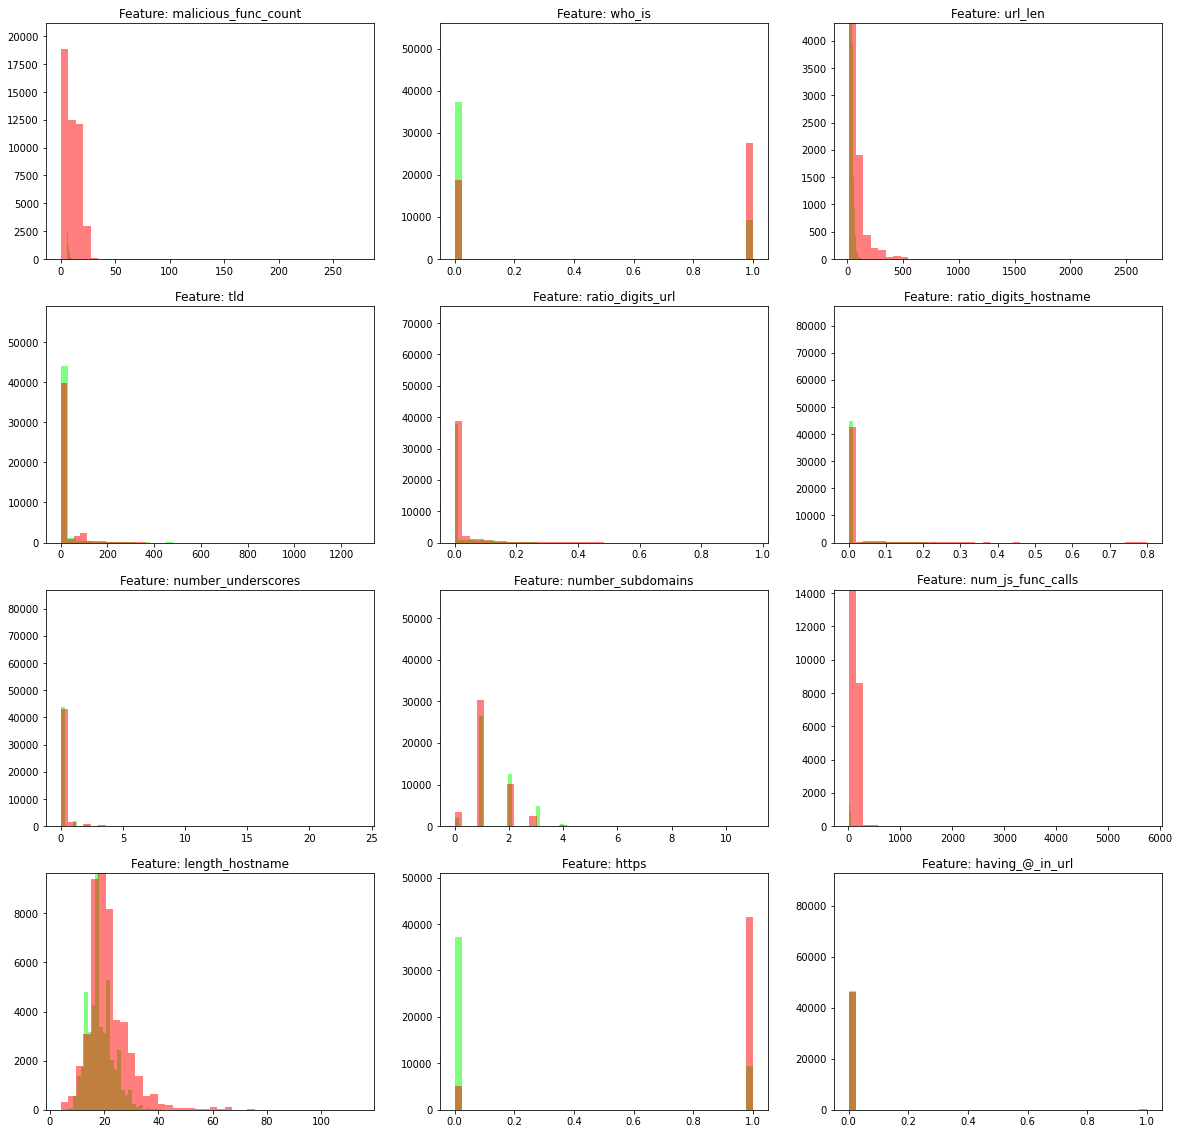

In [27]:
features = dataset_20_supp.drop(columns=['url', 'label', 'ip_add', 'content', 
                                         'hostname', 'js_obf_len', 'js_len']).columns[::-1]

n_bins = 40

fig, axs = plt.subplots(4, 3, figsize=(20,20))

# We can set the number of bins with the `bins` kwarg
feature_counter = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        current_feature = dataset_20_sample[features[feature_counter]]
        axs[i, j].hist(current_feature[dataset_20_sample['label']=='good'], n_bins, fc=(0, 1, 0, 0.5))
        axs[i, j].hist(current_feature[dataset_20_sample['label']=='bad'], n_bins, fc=(1, 0, 0, 0.5))
        axs[i, j].set_title(f'Feature: {features[feature_counter]}')
        if features[feature_counter] == 'js_len':
            axs[i, j].set_ylim([0, current_feature.value_counts().iloc[0]]) 
        else:
            axs[i, j].set_ylim([0, max(current_feature.value_counts())]) 
        feature_counter += 1
    if feature_counter > 14:
        break

plt.show()

### Plotly analysis

In [29]:
feature = 'malicious_func_count'
good_filter = dataset_20_sample[feature][dataset_20_sample['label'] == 'good']
bad_filter = dataset_20_sample[feature][dataset_20_sample['label'] == 'bad']


trace1 = go.Histogram(
    x=good_filter,
    name='Benign',
    yaxis='y2'

)

trace2 = go.Histogram(
    x=bad_filter,
    name='Malicious',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)

fig['layout'].update(height = 500, width = 800, title = f'Feature: {feature}',xaxis=dict(
      tickangle=-90
    ))
iplot(fig)

## Checkpoint 1: Preprocessed supplemented dataset

In [147]:
# dataset_20_supp.to_csv('supplemented_dataset_20.csv', index=False)
# dataset_20_sample.to_csv('supplemented_dataset_20_training_sample.csv', index=False)

In [148]:
dataset_20_supp = pd.read_csv('supplemented_dataset_20.csv')
dataset_20_sample = pd.read_csv('supplemented_dataset_20_training_sample.csv')

## Train-test-split

In [30]:
X = dataset_20_sample.drop(columns = ['label'])
y = np.array(dataset_20_sample['label'].apply(lambda x: 1 if 'bad' in x else 0))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [60]:
original_features = ['url', 'url_len', 'ip_add', #'latitude', 'longitude', 
                     'tld', 'who_is', 'https', 'num_js_func_calls', 'malicious_func_count','content']

to_drop = ['url', 'content', 'ip_add', 'hostname', 'js_obf_len', 'js_len']

## Variation 1
X_train_original_features = np.array(X_train[original_features].drop(columns=['url', 'content', 'ip_add']))
X_test_original_features =  np.array(X_test[original_features].drop(columns=['url', 'content', 'ip_add']))

## Variation 2
X_train_original_features_remove_js = np.array(X_train[original_features]\
.drop(columns=['malicious_func_count', 'num_js_func_calls'])\
.drop(columns=['url', 'content', 'ip_add']))

X_test_original_features_remove_js = np.array(X_test[original_features]\
.drop(columns=['malicious_func_count', 'num_js_func_calls'])\
.drop(columns=['url', 'content', 'ip_add']))

## Variation 3
X_train_custom_features = np.array(X_train.drop(columns=to_drop))
X_test_custom_features = np.array(X_test.drop(columns=to_drop))

## Variation 4
X_train_custom_features_without_js = np.array(X_train.drop(columns = ['malicious_func_count', 'num_js_func_calls'])\
                                              .drop(columns=to_drop))
X_test_custom_features_without_js = np.array(X_test.drop(columns = ['malicious_func_count', 'num_js_func_calls'])\
                                             .drop(columns=to_drop))

## Variation 5
X_train_transformer = X_train['url']
X_test_transformer = X_test['url']

## Naive Bayes

### Variation 1 - Original Dataset

In [61]:
gnb = GaussianNB()
gnb.fit(X_train_original_features, y_train)

GaussianNB()

In [62]:
y_pred = gnb.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.8562634356068008

In [63]:
confusion_matrix(y_test, y_pred)

array([[14839,   505],
       [ 3908, 11450]])

In [64]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7915    0.9671    0.8706     15344
   malicious     0.9578    0.7455    0.8384     15358

    accuracy                         0.8563     30702
   macro avg     0.8746    0.8563    0.8545     30702
weighted avg     0.8747    0.8563    0.8545     30702



### Variation 2 - Original Dataset with JS features removed

In [65]:
gnb = GaussianNB()
gnb.fit(X_train_original_features_remove_js, y_train)

GaussianNB()

In [66]:
y_pred = gnb.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8410201289818253

In [67]:
confusion_matrix(y_test, y_pred)

array([[12039,  3305],
       [ 1576, 13782]])

In [68]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8842    0.7846    0.8315     15344
   malicious     0.8066    0.8974    0.8496     15358

    accuracy                         0.8410     30702
   macro avg     0.8454    0.8410    0.8405     30702
weighted avg     0.8454    0.8410    0.8405     30702



### Variation 3 - Original Dataset + Custom Features

In [69]:
gnb = GaussianNB()
gnb.fit(X_train_custom_features, y_train)

GaussianNB()

In [70]:
y_pred = gnb.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.8307276398931666

In [71]:
confusion_matrix(y_test, y_pred)

array([[14966,   378],
       [ 4819, 10539]])

In [72]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7564    0.9754    0.8521     15344
   malicious     0.9654    0.6862    0.8022     15358

    accuracy                         0.8307     30702
   macro avg     0.8609    0.8308    0.8271     30702
weighted avg     0.8610    0.8307    0.8271     30702



### Variation 4 - Original Dataset without JS Features + Custom Features

In [73]:
gnb = GaussianNB()
gnb.fit(X_train_custom_features_without_js, y_train)

GaussianNB()

In [74]:
y_pred = gnb.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.5524395804833562

In [75]:
confusion_matrix(y_test, y_pred)

array([[14891,   453],
       [13288,  2070]])

In [76]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.5284    0.9705    0.6843     15344
   malicious     0.8205    0.1348    0.2315     15358

    accuracy                         0.5524     30702
   macro avg     0.6744    0.5526    0.4579     30702
weighted avg     0.6745    0.5524    0.4578     30702



## SVM

In [77]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}

### Variation 1 - Original Dataset

In [78]:
svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(X_train_original_features, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:   37.8s remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:   41.2s remaining:   48.7s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  1.0min remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.6min finished


[LibSVM]

GridSearchCV(cv=3, estimator=SVC(verbose=3), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [79]:
print(clf.best_params_)
print(clf.best_estimator_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001, verbose=3)


In [80]:
y_pred = clf.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9537163702690379

In [81]:
confusion_matrix(y_test, y_pred)

array([[15025,   319],
       [ 1102, 14256]])

In [82]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9317    0.9792    0.9548     15344
   malicious     0.9781    0.9282    0.9525     15358

    accuracy                         0.9537     30702
   macro avg     0.9549    0.9537    0.9537     30702
weighted avg     0.9549    0.9537    0.9537     30702



### Variation 2 - Original Dataset with JS features removed

In [83]:
svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(np.array(X_train_original_features_remove_js), np.array(y_train))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:  1.7min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:  2.9min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  7.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 22.2min finished


[LibSVM]

GridSearchCV(cv=3, estimator=SVC(verbose=3), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [84]:
print(clf.best_params_)
print(clf.best_estimator_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001, verbose=3)


In [85]:
y_pred = clf.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8577291381668947

In [86]:
confusion_matrix(y_test, y_pred)

array([[12916,  2428],
       [ 1940, 13418]])

In [87]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8694    0.8418    0.8554     15344
   malicious     0.8468    0.8737    0.8600     15358

    accuracy                         0.8577     30702
   macro avg     0.8581    0.8577    0.8577     30702
weighted avg     0.8581    0.8577    0.8577     30702



### Variation 3 - Original Dataset + Custom Features

In [88]:
svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(X_train_custom_features, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:   49.6s remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:   56.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  1.3min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.7min finished


[LibSVM]

GridSearchCV(cv=3, estimator=SVC(verbose=3), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [89]:
print(clf.best_params_)
print(clf.best_estimator_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001, verbose=3)


In [90]:
y_pred = clf.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9613705947495277

In [91]:
confusion_matrix(y_test, y_pred)

array([[14916,   428],
       [  758, 14600]])

In [92]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9516    0.9721    0.9618     15344
   malicious     0.9715    0.9506    0.9610     15358

    accuracy                         0.9614     30702
   macro avg     0.9616    0.9614    0.9614     30702
weighted avg     0.9616    0.9614    0.9614     30702



### Variation 4 - Original Dataset without JS Features + Custom Features

In [93]:
svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(X_train_custom_features_without_js, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:  2.4min remaining: 26.3min
/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:  3.1min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  4.7min remaining:   56.7s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  8.3min finished


[LibSVM]

GridSearchCV(cv=3, estimator=SVC(verbose=3), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [94]:
print(clf.best_params_)
print(clf.best_estimator_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001, verbose=3)


In [95]:
y_pred = clf.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8681193407595597

In [96]:
confusion_matrix(y_test, y_pred)

array([[13113,  2231],
       [ 1818, 13540]])

In [97]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8782    0.8546    0.8663     15344
   malicious     0.8585    0.8816    0.8699     15358

    accuracy                         0.8681     30702
   macro avg     0.8684    0.8681    0.8681     30702
weighted avg     0.8684    0.8681    0.8681     30702



## KNN

### Variation 1 - Original Dataset

In [98]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_original_features, y_train)

KNeighborsClassifier(n_neighbors=100)

In [99]:
y_pred = knn_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9365839358999414

In [100]:
confusion_matrix(y_test, y_pred)

array([[14405,   939],
       [ 1008, 14350]])

In [101]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9346    0.9388    0.9367     15344
   malicious     0.9386    0.9344    0.9365     15358

    accuracy                         0.9366     30702
   macro avg     0.9366    0.9366    0.9366     30702
weighted avg     0.9366    0.9366    0.9366     30702



### Variation 2 - Original Dataset with JS features removed

In [102]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_original_features_remove_js, y_train)

KNeighborsClassifier(n_neighbors=100)

In [103]:
y_pred = knn_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.83203048661325

In [104]:
confusion_matrix(y_test, y_pred)

array([[12547,  2797],
       [ 2360, 12998]])

In [105]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8417    0.8177    0.8295     15344
   malicious     0.8229    0.8463    0.8345     15358

    accuracy                         0.8320     30702
   macro avg     0.8323    0.8320    0.8320     30702
weighted avg     0.8323    0.8320    0.8320     30702



### Variation 3 - Original Dataset + Custom Features

In [106]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_custom_features, y_train)

KNeighborsClassifier(n_neighbors=100)

In [107]:
y_pred = knn_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9387010618200768

In [108]:
confusion_matrix(y_test, y_pred)

array([[14355,   989],
       [  893, 14465]])

In [109]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9414    0.9355    0.9385     15344
   malicious     0.9360    0.9419    0.9389     15358

    accuracy                         0.9387     30702
   macro avg     0.9387    0.9387    0.9387     30702
weighted avg     0.9387    0.9387    0.9387     30702



### Variation 4 - Original Dataset without JS Features + Custom Features

In [110]:
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_custom_features_without_js, y_train)

KNeighborsClassifier(n_neighbors=100)

In [111]:
y_pred = knn_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8191974464204287

In [112]:
confusion_matrix(y_test, y_pred)

array([[12558,  2786],
       [ 2765, 12593]])

In [113]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8196    0.8184    0.8190     15344
   malicious     0.8188    0.8200    0.8194     15358

    accuracy                         0.8192     30702
   macro avg     0.8192    0.8192    0.8192     30702
weighted avg     0.8192    0.8192    0.8192     30702



## XGBoost

### Variation 1 - Original Dataset

In [114]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_original_features, y_train)

[13:47:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
y_pred = xgboost_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9631620089896423

In [116]:
confusion_matrix(y_test, y_pred)

array([[14875,   469],
       [  662, 14696]])

In [117]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9574    0.9694    0.9634     15344
   malicious     0.9691    0.9569    0.9629     15358

    accuracy                         0.9632     30702
   macro avg     0.9632    0.9632    0.9632     30702
weighted avg     0.9632    0.9632    0.9632     30702



### Variation 2 - Original Dataset with JS features removed

In [118]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_original_features_remove_js, y_train)

[13:47:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
y_pred = xgboost_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8680216272555534

In [120]:
confusion_matrix(y_test, y_pred)

array([[13169,  2175],
       [ 1877, 13481]])

In [121]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8752    0.8583    0.8667     15344
   malicious     0.8611    0.8778    0.8693     15358

    accuracy                         0.8680     30702
   macro avg     0.8682    0.8680    0.8680     30702
weighted avg     0.8682    0.8680    0.8680     30702



### Variation 3 - Original Dataset + Custom Features

In [122]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_custom_features, y_train)

[13:47:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
y_pred = xgboost_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9696762425900592

In [124]:
confusion_matrix(y_test, y_pred)

array([[14912,   432],
       [  499, 14859]])

In [125]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9676    0.9718    0.9697     15344
   malicious     0.9717    0.9675    0.9696     15358

    accuracy                         0.9697     30702
   macro avg     0.9697    0.9697    0.9697     30702
weighted avg     0.9697    0.9697    0.9697     30702



### Variation 4 - Original Dataset without JS Features + Custom Features

In [126]:
xgboost_model = XGBClassifier(learning_rate=0.4)
xgboost_model.fit(X_train_custom_features_without_js, y_train)

[13:47:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [127]:
y_pred = xgboost_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8849912057846394

In [128]:
confusion_matrix(y_test, y_pred)

array([[13540,  1804],
       [ 1727, 13631]])

In [129]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8869    0.8824    0.8846     15344
   malicious     0.8831    0.8876    0.8853     15358

    accuracy                         0.8850     30702
   macro avg     0.8850    0.8850    0.8850     30702
weighted avg     0.8850    0.8850    0.8850     30702



## Adaboost

### Variation 1 - Original Dataset

In [130]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_original_features, y_train)

AdaBoostClassifier()

In [131]:
y_pred = adaboost_model.predict(X_test_original_features)
accuracy_score(y_test, y_pred)

0.9500683994528044

In [132]:
confusion_matrix(y_test, y_pred)

array([[14625,   719],
       [  814, 14544]])

In [133]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9473    0.9531    0.9502     15344
   malicious     0.9529    0.9470    0.9499     15358

    accuracy                         0.9501     30702
   macro avg     0.9501    0.9501    0.9501     30702
weighted avg     0.9501    0.9501    0.9501     30702



### Variation 2 - Original Dataset with JS features removed

In [134]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_original_features_remove_js, y_train)

AdaBoostClassifier()

In [135]:
y_pred = adaboost_model.predict(X_test_original_features_remove_js)
accuracy_score(y_test, y_pred)

0.8597159794150219

In [136]:
confusion_matrix(y_test, y_pred)

array([[12759,  2585],
       [ 1722, 13636]])

In [137]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8811    0.8315    0.8556     15344
   malicious     0.8406    0.8879    0.8636     15358

    accuracy                         0.8597     30702
   macro avg     0.8609    0.8597    0.8596     30702
weighted avg     0.8609    0.8597    0.8596     30702



### Variation 3 - Original Dataset + Custom Features

In [138]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_custom_features, y_train)

AdaBoostClassifier()

In [139]:
y_pred = adaboost_model.predict(X_test_custom_features)
accuracy_score(y_test, y_pred)

0.9550843593251254

In [140]:
confusion_matrix(y_test, y_pred)

array([[14685,   659],
       [  720, 14638]])

In [141]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.9533    0.9571    0.9552     15344
   malicious     0.9569    0.9531    0.9550     15358

    accuracy                         0.9551     30702
   macro avg     0.9551    0.9551    0.9551     30702
weighted avg     0.9551    0.9551    0.9551     30702



### Variation 4 - Original Dataset without JS Features + Custom Features

In [142]:
adaboost_model = AdaBoostClassifier(learning_rate=0.4)
adaboost_model.fit(X_train_custom_features_without_js, y_train)

AdaBoostClassifier(learning_rate=0.4)

In [143]:
y_pred = adaboost_model.predict(X_test_custom_features_without_js)
accuracy_score(y_test, y_pred)

0.8624193863591948

In [144]:
confusion_matrix(y_test, y_pred)

array([[12820,  2524],
       [ 1700, 13658]])

In [145]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8829    0.8355    0.8586     15344
   malicious     0.8440    0.8893    0.8661     15358

    accuracy                         0.8624     30702
   macro avg     0.8635    0.8624    0.8623     30702
weighted avg     0.8635    0.8624    0.8623     30702



## JavaScript Validation using tools

In [ ]:
dataset_20['content'].iloc[0].split('()')

In [219]:
js_content = dataset_20['content']

pbar = tqdm(len(js_content))
for index, content in enumerate(js_content):
    with open(f'./js_dataset_20/{index}_content.js', 'w') as f:
        f.write(content)
    pbar.update(1)
pbar.close()

1313575it [17:47, 1230.69it/s]


## Dataset Supplementation

In [242]:
phishtank_data = pd.read_csv('phishtank.csv')
phishtank_data.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,7145820,https://galiinfo3segur.000webhostapp.com/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T18:06:07+00:00,yes,2021-05-30T18:29:17+00:00,yes,Other
1,7145493,http://grup-youtuber-freefire2021.duckdns.org/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:02:32+00:00,yes,2021-05-30T18:01:23+00:00,yes,Other
2,7145470,http://xviralvideoxnew.duckdns.org/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:01:05+00:00,yes,2021-05-30T18:07:00+00:00,yes,Other
3,7145469,https://www.amazon-ol.top/signim/?openid.pape....,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:01:01+00:00,yes,2021-05-30T18:33:02+00:00,yes,Other
4,7145467,http://fringe-happy-scaffold.glitch.me/,http://www.phishtank.com/phish_detail.php?phis...,2021-05-30T14:00:52+00:00,yes,2021-05-30T18:06:04+00:00,yes,Other


## Transformers 

## Image Classification Approach

### Reading images

In [38]:
import cv2
from glob import glob as globlin

image_paths = globlin('./img_extraction/dataset_20_images/*.png')

benign_images = []
malicious_images = []
pbar = tqdm(total=len(image_paths))

for path in image_paths:
    image = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (512, 512))
    if 'bad' in path:
        malicious_images.append(image)
    else:
        benign_images.append(image)
    pbar.update(1)
pbar.close()

print(f'Starting Number of Malicious Images = {len(malicious_images)}')
print(f'Starting Number of Benign Images = {len(benign_images)}')

100%|██████████| 14097/14097 [02:14<00:00, 105.00it/s]

Starting Number of Malicious Images = 6101
Starting Number of Benign Images = 7996


### Removing images with a could not connect page, or white page

In [39]:
from skimage.metrics import structural_similarity as ssim
 
def cleave_error_images(reference_image, cutoff_score, image_list):
    cleave_index = []
    for i in tqdm(range(0, len(image_list))):
        try:
            ssim_noise = ssim(reference_image, image_list[i], multichannel=True)
            if ssim_noise >= cutoff_score:
                cleave_index.append(i)
        except:
            cleave_index.append(i)
    return cleave_index


reference_image = malicious_images[4]
malicious_images_idx = cleave_error_images(reference_image, 0.9, malicious_images)
benign_image_idx = cleave_error_images(reference_image, 0.9, benign_images)

print(f'Number of Malicious Images after deletion = {len(malicious_images) - len(malicious_images_idx)}')
print(f'Number of Benign Images after deletion = {len(benign_images) - len(benign_image_idx)}')

100%|██████████| 7996/7996 [06:43<00:00, 19.84it/s]

Number of Malicious Images after deletion = 6100
Number of Benign Images after deletion = 7996


In [40]:
new_malicious_images = np.delete(np.array(malicious_images), malicious_images_idx, axis=0)
new_benign_images = np.delete(np.array(benign_images), benign_image_idx, axis=0)

In [41]:
np.savez('./img_extraction/malicious_images.npz', new_malicious_images)
np.savez('./img_extraction/benign_images.npz', new_benign_images)

### Image checkpoint

In [247]:
malicious_img = np.load('./img_extraction/malicious_images.npz', allow_pickle=True)['arr_0']
benign_img = np.load('./img_extraction/benign_images.npz', allow_pickle=True)['arr_0']

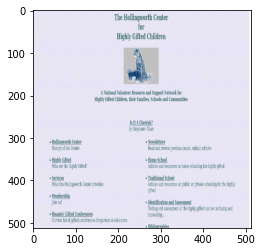

In [260]:
plt.imshow(benign_img[3])

In [ ]:
malicious_img

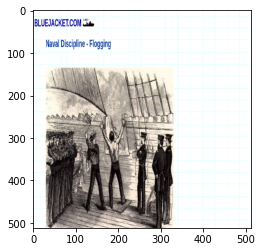

In [262]:
plt.imshow(malicious_img[2])

 ### Machine Learning 

In [43]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1144343241740423126]

In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

#### Train-test-split

In [44]:
import tensorflow as tf

In [45]:
y_malicious = np.full(len(malicious_img), 1)
y_benign = np.full(len(benign_img), 0)             

labels_df = np.array(np.concatenate([y_malicious, y_benign]).astype(np.float32))

In [46]:
image_df = np.array(np.concatenate([malicious_img, benign_img]))

# image_df = [image_df[i].astype(np.int) for i in tqdm(range(len(image_df)))]

In [47]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(image_df, labels_df, test_size=0.33, random_state=42)

#### Lenet-5

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=X_train_img[0].shape),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=1, activation = 'softmax')
])

In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(X_train_img, y_train_img, #validation_data=(X_valid_NN, y_valid_NN), 
                          epochs=15, batch_size=256, verbose=True)

Epoch 1/15
37/37 [==============================] - 638s 17s/step - loss: 11943.7792 - accuracy: 0.4305
Epoch 2/15
 4/37 [==>...........................] - ETA: 9:47 - loss: 213.0984 - accuracy: 0.4080 

KeyboardInterrupt: 

In [ ]:
y_pred = (model.predict(X_test_img) > 0.5).astype("int32")

accuracy_score(y_test_img, y_pred)

In [ ]:
confusion_matrix(y_test_img, y_pred)

#### Pretrained inception V3

In [ ]:
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=X_train_img[0].shape,
    pooling=None, classes=1000, classifier_activation=None
)

for layer in inception_model.layers:
    layer.trainable = False
x = Flatten()(inception_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(75, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

inception_model = tf.keras.Model(inception_model.input, x)
#inception_model.summary()

In [ ]:
epochs = 5
batch_size = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, name='adam')
loss_function = tf.keras.losses.binary_crossentropy

inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = inception_model.fit(x=X_train_img,
                   y=y_train_img,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_split=0.2)

In [ ]:
y_pred_proba = inception_model.predict(X_test_img)
y_pred = np.argmax(y_pred_proba, axis=-1)
accuracy_score(y_test_img, y_pred)

In [ ]:
confusion_matrix(y_test_img, y_pred)